Implementation of main prompt performance belief framework and subsequent search and search space construction
algorithms.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import itertools

In [2]:
def beta_posterior(trials, prior_a=1, prior_b=1):
    n = len(trials)
    k = trials.sum()
    dist_obj = stats.beta(a=prior_a + k, b=prior_b + n - k)
    dist_obj.alpha = prior_a + k
    dist_obj.beta = prior_b + n - k
    return dist_obj


def plot_dists(dists, figsize=(6, 2.8), storage_path=None):
    fig, ax = plt.subplots(figsize=figsize)

    x = np.linspace(0, 1, 1000)
    colorset = [
        "blue",
        "green",
        "red",
        "purple",
        "orange",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    for i, post in enumerate(dists):
        y = post.pdf(x)

        color = colorset[i % len(colorset)]
        ax.plot(x, y, label=f"Dist. {i+1}", color=color, linewidth=1)
        ax.axvline(
            post.mean(),
            color=color,
            linestyle="--",
            label=f"Dist. {i+1} mean: {post.mean():.2f}",
            alpha=0.5,
            linewidth=1,
        )

    ax.legend()

    # despine
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if storage_path:
        fig.savefig(storage_path, dpi=300)

0.02090961893364208


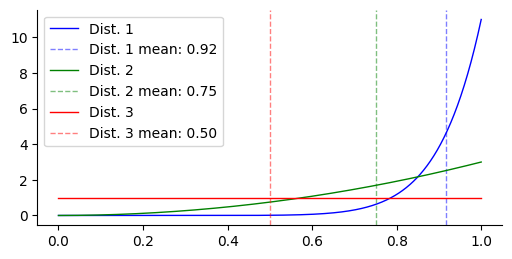

In [3]:
n_evals = [10, 2, 0]
true_performances = [0.99, 0.5, 0.4]

np.random.seed(0)
evals = [stats.bernoulli.rvs(p, size=n) for p, n in zip(true_performances, n_evals)]

dists = [beta_posterior(e) for e in evals]

plot_dists(dists, storage_path="op_eval_plot1.png")


def expected_regret(evals, n_samples=1000000):
    posteriors = [beta_posterior(e) for e in evals]
    chosen_prompt = np.argmax([p.mean() for p in posteriors])

    samples = [p.rvs(size=n_samples) for p in posteriors]
    regrets = np.maximum.reduce(samples, axis=0) - samples[chosen_prompt]
    return np.mean(regrets)


print(expected_regret(evals))

In [4]:
for prompt_idx in range(len(evals)):
    regrets = []
    for add_eval in [1, 0]:
        new_evals = evals.copy()
        new_evals[prompt_idx] = np.append(new_evals[prompt_idx], add_eval)
        regrets.append(expected_regret(new_evals))

    expected_new_expected_regret = np.sum(
        regrets * np.array([dists[prompt_idx].mean(), 1 - dists[prompt_idx].mean()])
    )
    print(
        f"Expected regret with adding eval to prompt {prompt_idx+1}: {expected_new_expected_regret}"
    )

Expected regret with adding eval to prompt 1: 0.020875539228134555
Expected regret with adding eval to prompt 2: 0.02088822324691805
Expected regret with adding eval to prompt 3: 0.020852193835388312


In [5]:
import numpy as np
from scipy import stats, integrate


def expected_regret_leg(posteriors, n_samples=10000000):
    chosen_prompt = np.argmax([p.mean() for p in posteriors])

    samples = [p.rvs(size=n_samples) for p in posteriors]
    regrets = np.maximum.reduce(samples, axis=0) - samples[chosen_prompt]
    return np.mean(regrets)


def expected_regret_analytical(posteriors):
    """
    Calculate expected regret using refined analytical integration.

    Args:
    posteriors (list): List of scipy.stats.beta objects representing the posteriors.

    Returns:
    float: Expected regret
    """
    n = len(posteriors)
    chosen_prompt = max(range(n), key=lambda i: posteriors[i].mean())
    chosen_post = posteriors[chosen_prompt]

    def conditional_mean(dist, x):
        """Calculate the conditional mean of a distribution up to x."""
        if x <= 0:
            return 0
        partial_expect = integrate.quad(
            lambda t: t * dist.pdf(t), 0, x, epsrel=1.49 - 10
        )[0]
        return partial_expect / dist.cdf(x)

    def integrand(x):
        regret = 0
        for i, post in enumerate(posteriors):
            if i != chosen_prompt:
                # Probability that prompt i is the best
                prob_best = post.pdf(x)
                for j, other_post in enumerate(posteriors):
                    if j not in [i, chosen_prompt]:
                        prob_best *= other_post.cdf(x)

                # Expected regret if prompt i is the best
                expected_diff = x - conditional_mean(chosen_post, x)
                regret += prob_best * expected_diff

        return regret

    expected_regret, _ = integrate.quad(integrand, 0, 1, epsrel=1.49 - 10)
    return expected_regret


def expected_regret_importance_sampling(posteriors, n_samples=1000000):
    """
    Calculate expected regret using importance sampling.

    Args:
    posteriors (list): List of scipy.stats.beta objects representing the posteriors.
    n_samples (int): Number of samples to use.

    Returns:
    float: Expected regret
    """
    n = len(posteriors)
    chosen_prompt = max(range(n), key=lambda i: posteriors[i].mean())

    # Use a mixture of beta distributions as the proposal distribution
    mixture_weights = np.array([p.mean() for p in posteriors])
    mixture_weights /= mixture_weights.sum()

    samples = np.zeros(n_samples)
    for i, (post, weight) in enumerate(zip(posteriors, mixture_weights)):
        samples += weight * post.rvs(n_samples)

    max_samples = np.maximum.reduce([p.rvs(n_samples) for p in posteriors])
    regrets = max_samples - posteriors[chosen_prompt].rvs(n_samples)

    importance_weights = np.prod([p.pdf(samples) for p in posteriors], axis=0) / np.sum(
        [w * p.pdf(samples) for w, p in zip(mixture_weights, posteriors)], axis=0
    )

    return np.mean(regrets * importance_weights)


def expected_regret_stratified(posteriors, n_strata=100, n_samples_per_stratum=1000):
    """
    Calculate expected regret using stratified sampling.

    Args:
    posteriors (list): List of scipy.stats.beta objects representing the posteriors.
    n_strata (int): Number of strata to use.
    n_samples_per_stratum (int): Number of samples per stratum.

    Returns:
    float: Expected regret
    """
    n = len(posteriors)
    chosen_prompt = max(range(n), key=lambda i: posteriors[i].mean())

    strata_bounds = np.linspace(0, 1, n_strata + 1)
    regret_sum = 0

    for lower, upper in zip(strata_bounds[:-1], strata_bounds[1:]):
        stratum_samples = np.random.uniform(lower, upper, n_samples_per_stratum)
        max_samples = np.maximum.reduce([p.ppf(stratum_samples) for p in posteriors])
        regrets = max_samples - posteriors[chosen_prompt].ppf(stratum_samples)
        regret_sum += np.mean(regrets) * (upper - lower)

    return regret_sum


# Example usage
alpha = [2, 3, 4]
beta = [2, 4, 2]
dists = [stats.beta(a, b) for a, b in zip(alpha, beta)]

print(f"Legacy: {expected_regret_leg(dists)}")
print(f"Analytical: {expected_regret_analytical(dists)}")
print(f"Importance Sampling: {expected_regret_importance_sampling(dists)}")
# print(f"Stratified Sampling: {expected_regret_stratified(posteriors)}")

# # Confidence interval calculation
# def confidence_interval(func, posteriors, n_bootstrap=1000, confidence_level=0.95):
#     results = [func(posteriors) for _ in range(n_bootstrap)]
#     return np.percentile(results, [(1-confidence_level)/2 * 100, (1+confidence_level)/2 * 100])

# print(f"Confidence Interval (Importance Sampling): {confidence_interval(expected_regret_importance_sampling, posteriors)}")

Legacy: 0.06511773276616714
Analytical: 0.14003619768470912
Importance Sampling: 0.127485666416176


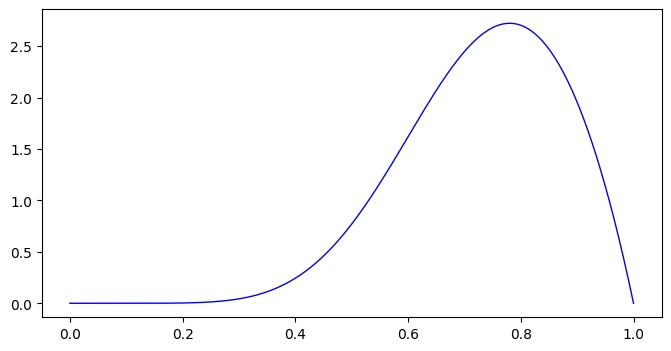

In [6]:
def maximum_dist(x, posteriors: list):
    prob = 0
    for post in posteriors:
        prob2 = 1
        for post2 in posteriors:
            if post == post2:
                prob2 *= post2.pdf(x)
                continue
            prob2 *= post2.cdf(x)
        prob += prob2
    return prob


x = np.linspace(0, 1, 1000)
y = maximum_dist(x, dists)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y, label="Maximum distribution", color="blue", linewidth=1)

In [7]:
from scipy.special import kl_div


# expected KL divergence between the maximum distribution before and after an additional evaluation
def expected_max_dist_kl_div(evals, add_eval_prompt):
    x = np.linspace(0, 1, 1000)
    posteriors_init = [beta_posterior(e) for e in evals]
    initial_max_dist = maximum_dist(x, posteriors_init)

    p_success = posteriors_init[add_eval_prompt].mean()

    expected_kl_div = 0
    for eval_outcome, p in zip([1, 0], [1 - p_success, p_success]):
        evals_copy = evals.copy()
        evals_copy[add_eval_prompt] = np.append(
            evals_copy[add_eval_prompt], eval_outcome
        )

        posteriors_new = [beta_posterior(e) for e in evals_copy]
        new_max_dist = maximum_dist(x, posteriors_new)

        # kl divergence between the maximum distribution before and after an additional evaluation
        kl_divergence = kl_div(new_max_dist, initial_max_dist).sum()
        expected_kl_div += kl_divergence * p

    return expected_kl_div


expected_kl_div = expected_max_dist_kl_div(evals, 2)
print(f"Expected KL divergence: {expected_kl_div}")

Expected KL divergence: 1.984305236051417


In [8]:
from scipy.special import kl_div


def expected_kl_divergence(evals_init):
    prior = beta_posterior(evals_init)
    posterior_success = beta_posterior(np.append(evals_init, 1))
    posterior_failure = beta_posterior(np.append(evals_init, 0))

    x = np.linspace(0, 1, 1000)
    kl_success = kl_div(posterior_success.pdf(x), prior.pdf(x)).sum()
    kl_failure = kl_div(posterior_failure.pdf(x), prior.pdf(x)).sum()

    p_success = prior.mean()
    return p_success * kl_success + (1 - p_success) * kl_failure


expected_kl_divergence(evals[2])

np.float64(193.6488308449836)

### Distribution over final picked prompt performance

Consider decision sequence:
- eval prompt 1
- eval prompt 2
- eval prompt 1
- eval prompt 2
- sample new prompt
- eval prompt 3
- eval prompt 3
- sample new prompt
- eval prompt 4
- eval prompt 4

What is now, before having done anything, our belief over the performance of the prompt will we choose in the end?

In theory there are 3 possible outcomes. The chosen prompt to sample prompt 3 has 2 positive evals, 1 positive eval or both
have zero positive evals.

Assumptions
- we assume a model of how the linear combination posterior (of all evaluation possibilities before a new sample) translates to the distribution over the performance of the newly sampled prompt
- we assume priors for initial prompts

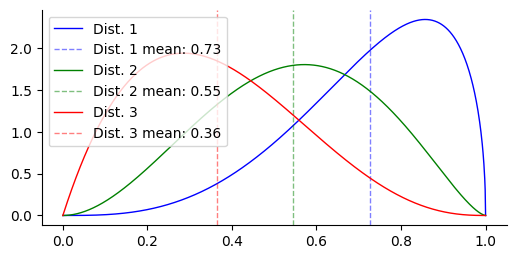

In [9]:
prompt1 = beta_posterior(np.array([]), prior_a=2.0, prior_b=1.5)
prompt2 = beta_posterior(np.array([]), prior_a=2.0, prior_b=1.5)
post1 = beta_posterior(np.array([1, 1]), prior_a=2.0, prior_b=1.5)  # var1
post2 = beta_posterior(np.array([1, 0]), prior_a=2.0, prior_b=1.5)  # var2
post3 = beta_posterior(np.array([0, 0]), prior_a=2.0, prior_b=1.5)  # var3

plot_dists([post1, post2, post3])

In [10]:
var1_prob = 1 - (1 - prompt1.mean() ** 2) * (1 - prompt2.mean() ** 2)
var2_prob = (
    1
    - (1 - prompt1.mean()) ** 2 * (1 - prompt2.mean()) ** 2
    - (1 - (1 - prompt1.mean() ** 2) * (1 - prompt2.mean() ** 2))
)
var3_prob = (1 - prompt1.mean()) ** 2 * (1 - prompt2.mean()) ** 2

var1_prob, var2_prob, var3_prob

(np.float64(0.5464389837567679),
 np.float64(0.41982507288629745),
 np.float64(0.033735943356934625))

In [11]:
class LinearCombination(stats.rv_continuous):
    def __init__(self, distributions, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.distributions = distributions
        self.weights = weights

    def _pdf(self, x):
        return sum(w * d.pdf(x) for w, d in zip(self.weights, self.distributions))

    def _cdf(self, x):
        return sum(w * d.cdf(x) for w, d in zip(self.weights, self.distributions))

    def _rvs(self):
        choice = np.random.choice(len(self.distributions), p=self.weights)
        return self.distributions[choice].rvs()

    def mean(self):
        return sum(w * d.mean() for w, d in zip(self.weights, self.distributions))


# even before having made any actual evaluations, this is our belief over the mean of the prompt we choose to sample prompt 3 from
prompt3_prior = LinearCombination(
    [post1, post2, post3], [var1_prob, var2_prob, var3_prob]
)

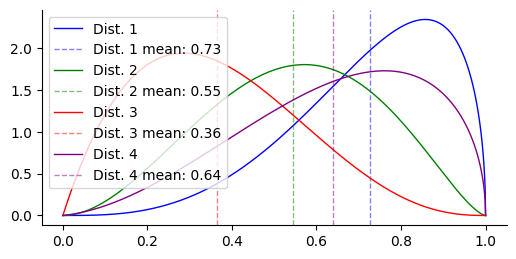

In [12]:
plot_dists([post1, post2, post3, prompt3_prior])

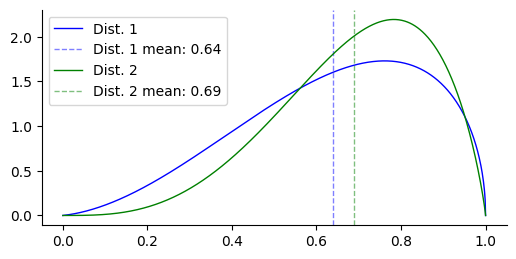

In [13]:
# the question is now to go from this prior over the mean to the actual distribution that models our belief over the performance of that new prompt sampled from the chosen one
# we (prob) need to integrate the new distribution over the possible mean values and their probabilities given prompt3_mean_belief
S = 6
prompt3_mean_belief_adjusted = min([1, prompt3_prior.mean() + 0.05])
alpha = prompt3_mean_belief_adjusted * S
beta = S - alpha

prompt3 = beta_posterior(np.array([]), prior_a=alpha, prior_b=beta)
plot_dists([prompt3_prior, prompt3])

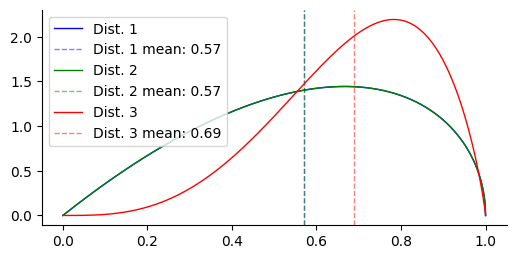

In [14]:
# resulting in these three prompts for which we have following beliefs over their performance:
plot_dists([prompt1, prompt2, prompt3])

In [15]:
# binomial distribution
binom = stats.binom(n=6, p=0.5)
binom.pmf(5)

np.float64(0.09375000000000004)

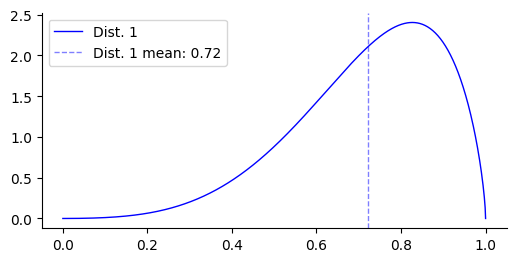

In [16]:
# now again, as before we have three different possible outcomes for how many evaluations were positive for the prompt chosen to sample prompt 4
# however, this time the cases of promp1 having had two positive evals and prompt3 having two positive evals are not the same as they lead to different beliefs over the performance of the new prompt

# this time we try to implement the computation of the distribution over the mean of the picked prompt to sample from in a general way
# for each prompt existing, we have three possibilities of number of positive evals
# since we have now three prompts we have 3^3 different combinations
# each combination has a certain probability and a certain set posterior of which the one with the highest mean represents our foundation for the belief of the new prompt we will pick (prompt 4)

n_evals = [2, 2, 2]
prompts = [prompt1, prompt2, prompt3]

# create binomial distributions for each prompt over the number of positive evals
binomial_dists = [
    stats.binom(n=n, p=prompt.mean()) for prompt, n in zip(prompts, n_evals)
]

# Generate all possible combinations of evaluation outcomes
possible_eval_outcomes = []
for prompt_evals in itertools.product(*[range(n + 1) for n in n_evals]):
    possible_eval_outcomes.append(prompt_evals)

final_belief_posteriors = []
final_belief_posterior_probabilities = []
for eval_outcome in possible_eval_outcomes:
    outcome_probability = 1
    for i, k in enumerate(eval_outcome):
        outcome_probability *= binomial_dists[i].pmf(k)

    # create posteriors and pick the one with the highest mean
    posts = []
    for i, k in enumerate(eval_outcome):
        posts.append(
            beta_posterior(
                np.array([1] * k + [0] * (n_evals[i] - k)),
                prior_a=prompts[i].alpha,
                prior_b=prompts[i].beta,
            )
        )

    highest_mean_post = np.argmax([p.mean() for p in posts])

    # TODO: performance increase by not having identical dists in the list multiple times

    final_belief_posteriors.append(posts[highest_mean_post])
    final_belief_posterior_probabilities.append(outcome_probability)

# this is now our belief over the performance of the prompt we will in the future pick to sample prompt 4 from
linear_combination = LinearCombination(
    final_belief_posteriors, final_belief_posterior_probabilities
)
plot_dists([linear_combination])

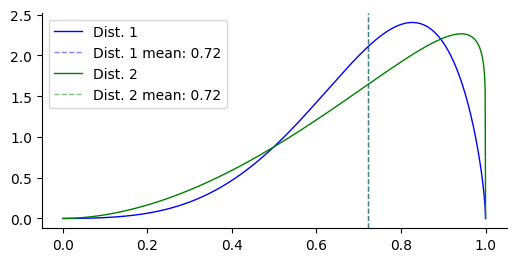

In [17]:
# we now again go from the belief of the performance of the prompt we sample from to the
# belief of the performance of the prompt we sample like before
S = 4
expected_improvement = 0.00
new_prompt_performance_belief_mean = min(
    [1, linear_combination.mean() + expected_improvement]
)
alpha = new_prompt_performance_belief_mean * S
beta = S - alpha

prompt4 = beta_posterior(np.array([]), prior_a=alpha, prior_b=beta)
plot_dists([linear_combination, prompt4])

In [18]:
def expected_final_pick_performance(posteriors):
    chosen_prompt = np.argmax([p.mean() for p in posteriors])
    return posteriors[chosen_prompt].mean()


expected_final_pick_performance([prompt1, prompt2, prompt3, prompt4])

np.float64(0.7211109473754798)

## Framework for search

In [19]:
from enum import Enum, auto
from scipy.special import comb


class LLMCallType(Enum):
    EVAL = auto()
    SAMPLE = auto()


class LLMCall:
    def __init__(self, call_type: LLMCallType, prompt_idx: int = None):
        self.call_type = call_type
        self.prompt_idx = prompt_idx

    def __repr__(self) -> str:
        if self.prompt_idx is not None:
            return f"EVAL-P{self.prompt_idx}"
        else:
            return f"SAMPLE"


def outcome_matrix_fn(n_values):
    ranges = [np.arange(n + 1) for n in n_values]
    grid = np.meshgrid(*ranges, indexing="ij")

    return np.stack(grid, axis=-1).reshape(-1, len(n_values))


def future_picked_prompt_belief_expec(prompts: np.array, n_evals: np.array):
    # create binomial distributions for each prompt over the number of positive evals
    alphas = prompts[:, 0]
    betas = prompts[:, 1]

    success_probs = alphas / prompts.sum(axis=1)

    # generate all possible combinations of evaluation outcomes
    outcome_matrix = outcome_matrix_fn(n_evals)

    bin_coefficient_matrix = comb(n_evals, outcome_matrix)
    binom_pmfs = (
        bin_coefficient_matrix
        * success_probs**outcome_matrix
        * (1 - success_probs) ** (n_evals - outcome_matrix)
    )
    outcome_probs = binom_pmfs.prod(axis=1)

    # compute posteriors
    new_alphas = alphas + outcome_matrix
    new_betas = betas + (n_evals - outcome_matrix)
    posterior_means = new_alphas / (new_alphas + new_betas)

    picked_posteriors = posterior_means.max(axis=1)

    expected_picked_posterior_mean = (picked_posteriors * outcome_probs).sum()
    return expected_picked_posterior_mean


def trajectory_expected_performance(
    prompts,
    trajectory: list[LLMCall],
    S=6,
    expected_improvement=0.15,
    prior_alpha=1.9,
    prior_beta=3.4,
):
    n_evals = np.array([0] * len(prompts))
    for action in trajectory:
        if action.call_type == LLMCallType.EVAL:
            n_evals[action.prompt_idx] += 1
        elif action.call_type == LLMCallType.SAMPLE:
            # at this point we need to compute the distribution over
            # the performance of the prompt
            # we will pick to sample the new prompt
            belief_over_sample_base = future_picked_prompt_belief_expec(
                prompts, n_evals
            )

            base_prior_mean = prior_alpha / (prior_alpha + prior_beta)
            delta = belief_over_sample_base - base_prior_mean

            alpha = prior_alpha + delta * expected_improvement
            beta = prior_beta + (prior_alpha - alpha)

            prompts = np.append(prompts, np.array([[alpha, beta]]), axis=0)
            n_evals = np.append(n_evals, 0)

    return prompts, future_picked_prompt_belief_expec(prompts, n_evals)

In [20]:
prompts = np.array(
    [
        [2.0, 1.5],
        [2.0, 1.5],
        [2.0, 1.5],
    ]
)

trajectory = [
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 1),
    LLMCall(LLMCallType.EVAL, 2),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 1),
    LLMCall(LLMCallType.EVAL, 2),
    LLMCall(LLMCallType.SAMPLE),
    LLMCall(LLMCallType.EVAL, 3),
    LLMCall(LLMCallType.EVAL, 3),
]

_, final_performance_belief = trajectory_expected_performance(
    prompts, trajectory, expected_improvement=0.0
)

In [21]:
def flatten(xss):
    return [x for xs in xss for x in xs]


def create_exhaustive_trajectories(starting_set_size: int, tree_depth: int):
    trajectories = []

    # every possible way of performing or not performing new prompt samplings
    sampling_configs = itertools.product(*[[False, True]] * tree_depth)

    # for every sampling configuration we need to check every possible way to
    # perform evaluations between the samples
    for sampling_config in sampling_configs:
        avail_prompts = starting_set_size
        current_window_size = 0
        trajectory_components = []
        for i in range(len(sampling_config)):
            if sampling_config[i]:
                avail_prompts += 1
                trajectory_components.append([(LLMCall(LLMCallType.SAMPLE),)])
            else:
                current_window_size += 1
                if i + 1 >= len(sampling_config) or sampling_config[i + 1]:
                    trajectory_components.append(
                        itertools.combinations_with_replacement(
                            [
                                LLMCall(LLMCallType.EVAL, i)
                                for i in range(avail_prompts)
                            ],
                            current_window_size,
                        )
                    )
                    current_window_size = 0

        # combinations across all options for each component
        sampling_config_trajectories = itertools.product(*trajectory_components)
        trajectories += sampling_config_trajectories

    # flatten each component combination into trajectory
    for i in range(len(trajectories)):
        trajectories[i] = flatten(trajectories[i])
    return trajectories


trajectories = create_exhaustive_trajectories(3, 8)
print(len(trajectories))

68447


In [22]:
# best_traj = (None, 0)
# for traj in trajectories:
#     performance_beliefs, final_performance_belief = trajectory_expected_performance(prompts, traj, expected_improvement=0.0, S=3)

#     if final_performance_belief > best_traj[1]:
#         best_traj = (traj, final_performance_belief)

# best_traj

In [23]:
trajectory_1 = [
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 1),
    LLMCall(LLMCallType.EVAL, 2),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 1),
    LLMCall(LLMCallType.EVAL, 2),
    LLMCall(LLMCallType.SAMPLE),
    LLMCall(LLMCallType.EVAL, 3),
    LLMCall(LLMCallType.EVAL, 3),
]

trajectory_2 = [
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 1),
    LLMCall(LLMCallType.EVAL, 2),
    LLMCall(LLMCallType.SAMPLE),
    LLMCall(LLMCallType.SAMPLE),
    LLMCall(LLMCallType.SAMPLE),
    LLMCall(LLMCallType.EVAL, 4),
    LLMCall(LLMCallType.EVAL, 4),
    LLMCall(LLMCallType.EVAL, 4),
]

trajectory_3 = [
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 1),
    LLMCall(LLMCallType.EVAL, 2),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.SAMPLE),
    LLMCall(LLMCallType.EVAL, 3),
    LLMCall(LLMCallType.EVAL, 3),
    LLMCall(LLMCallType.EVAL, 3),
    LLMCall(LLMCallType.SAMPLE),
]

prompts = np.array(
    [
        [2.0, 1.5],
        [2.0, 1.5],
        [2.0, 1.5],
    ]
)

_, final_performance_belief = trajectory_expected_performance(
    prompts, trajectory_1, expected_improvement=0.0
)

final_performance_belief

np.float64(0.6708397177226246)

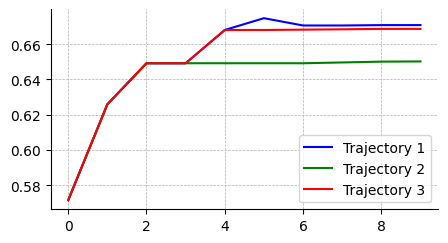

In [24]:
def final_performance_belief_traj(prompts, trajectory, expected_improvement):
    results = []
    for i in range(len(trajectory) + 1):
        _, final_performance_belief = trajectory_expected_performance(
            prompts, trajectory[0:i], expected_improvement=expected_improvement
        )
        results.append(final_performance_belief)
    return results


fig, ax = plt.subplots(figsize=(5, 2.6))

ax.plot(
    final_performance_belief_traj(prompts, trajectory_1, 0.0),
    color="blue",
    label="Trajectory 1",
    zorder=2,
)
ax.plot(
    final_performance_belief_traj(prompts, trajectory_2, 0.0),
    color="green",
    label="Trajectory 2",
    zorder=2,
)
ax.plot(
    final_performance_belief_traj(prompts, trajectory_3, 0.0),
    color="red",
    label="Trajectory 3",
    zorder=2,
)

# add grid
ax.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=1)

# despine
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend()

fig.savefig("op_eval_plot2.png", dpi=300)

In [25]:
# fig, ax = plt.subplots(figsize=(8, 4))

# for traj in trajectories:
#     t = final_performance_belief_traj(prompts, traj, 0.0)

#     if t[-1] == best_traj[1]:
#         ax.plot(t, color='red', alpha=1.0, linewidth=1, zorder=2)
#     else:
#         ax.plot(t, color='blue', alpha=0.1, linewidth=1, zorder=1)

# # despine
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# fig.savefig("op_eval_plot3.png", dpi=300)

In [26]:
p = beta_posterior(np.array([1]), prior_a=2.0, prior_b=1.5)
p2 = beta_posterior(np.array([1, 1, 1, 1, 1, 1, 0, 0]), prior_a=2.0, prior_b=1.5)

prompts = np.array(
    [
        [p.alpha, p.beta],
        [p2.alpha, p2.beta],
        [p2.alpha, p2.beta],
        [p2.alpha, p2.beta],
    ]
)

trajectory_1 = [
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 0),
    LLMCall(LLMCallType.EVAL, 0),
]

trajectory_2 = [
    LLMCall(LLMCallType.SAMPLE),
    LLMCall(LLMCallType.EVAL, 4),
    LLMCall(LLMCallType.SAMPLE),
    LLMCall(LLMCallType.EVAL, 5),
    LLMCall(LLMCallType.SAMPLE),
    LLMCall(LLMCallType.EVAL, 6),
]


val1 = final_performance_belief_traj(prompts, trajectory_1, 0.0)
val2 = final_performance_belief_traj(prompts, trajectory_2, 0.0)

val1, val2

([np.float64(0.6956521739130435),
  np.float64(0.7167325428194994),
  np.float64(0.7283537718320328),
  np.float64(0.7265700483091787),
  np.float64(0.7249534274257207),
  np.float64(0.7284986486613743),
  np.float64(0.7272789237362506),
  np.float64(0.723643665135882),
  np.float64(0.7257811971928987),
  np.float64(0.7251830400740628),
  np.float64(0.7228604363671947),
  np.float64(0.7229778525391837)],
 [np.float64(0.6956521739130435),
  np.float64(0.6956521739130435),
  np.float64(0.6956521739130435),
  np.float64(0.6956521739130435),
  np.float64(0.6956521739130437),
  np.float64(0.6956521739130437),
  np.float64(0.6956521739130436)])

In [27]:
trajectories = create_exhaustive_trajectories(4, 6)
print(len(trajectories))

best_traj = (None, 0)
for traj in trajectories:
    performance_beliefs, final_performance_belief = trajectory_expected_performance(
        prompts, traj, expected_improvement=0.0, S=3
    )

    if final_performance_belief > best_traj[1]:
        best_traj = (traj, final_performance_belief)

best_traj

6960


([EVAL-P0, EVAL-P0, EVAL-P0, EVAL-P1, EVAL-P1, EVAL-P2],
 np.float64(0.7480757694028377))

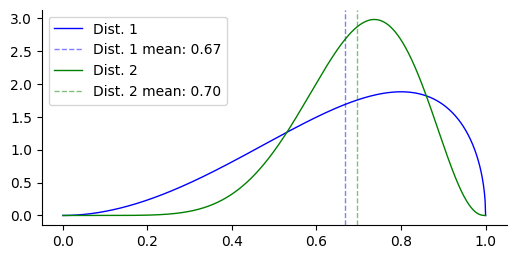

In [28]:
plot_dists([p, p2], storage_path="op_eval_plot5.png")

In [29]:
def optimal_action(prompts, search_depth=5, expected_improvement=0.0, S=3):
    trajectories = create_exhaustive_trajectories(len(prompts), search_depth)

    best_traj = (None, 0)
    for traj in trajectories:
        _, final_performance_belief = trajectory_expected_performance(
            prompts, traj, expected_improvement=expected_improvement, S=S
        )

        if final_performance_belief > best_traj[1]:
            best_traj = (traj, final_performance_belief)

    return best_traj[0][0]


optimal_action(prompts, search_depth=5, expected_improvement=0.0, S=3)

EVAL-P0

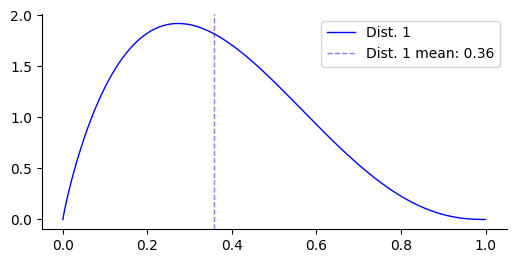

In [30]:
plot_dists([beta_posterior(np.array([]), 1.9, 3.4)])

In [31]:
action_seq = []
for i in range(9):
    action_seq += [LLMCall(LLMCallType.EVAL, i)] * 5 + [LLMCall(LLMCallType.SAMPLE)]
action_seq = action_seq[:-1]

In [32]:
prompts = np.array([[1.9, 3.4]])

_, final_performance_belief = trajectory_expected_performance(
    prompts, action_seq, expected_improvement=0.14, S=3
)
final_performance_belief

np.float64(0.5169399103764748)

In [33]:
action_seq

[EVAL-P0,
 EVAL-P0,
 EVAL-P0,
 EVAL-P0,
 EVAL-P0,
 SAMPLE,
 EVAL-P1,
 EVAL-P1,
 EVAL-P1,
 EVAL-P1,
 EVAL-P1,
 SAMPLE,
 EVAL-P2,
 EVAL-P2,
 EVAL-P2,
 EVAL-P2,
 EVAL-P2,
 SAMPLE,
 EVAL-P3,
 EVAL-P3,
 EVAL-P3,
 EVAL-P3,
 EVAL-P3,
 SAMPLE,
 EVAL-P4,
 EVAL-P4,
 EVAL-P4,
 EVAL-P4,
 EVAL-P4,
 SAMPLE,
 EVAL-P5,
 EVAL-P5,
 EVAL-P5,
 EVAL-P5,
 EVAL-P5,
 SAMPLE,
 EVAL-P6,
 EVAL-P6,
 EVAL-P6,
 EVAL-P6,
 EVAL-P6,
 SAMPLE,
 EVAL-P7,
 EVAL-P7,
 EVAL-P7,
 EVAL-P7,
 EVAL-P7,
 SAMPLE,
 EVAL-P8,
 EVAL-P8,
 EVAL-P8,
 EVAL-P8,
 EVAL-P8]